### imports

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision.transforms as T
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint



from neuralop.models import FNO2d, FNO

from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def step_fd(u, kappa, dt, dx):

    u_pad = F.pad(u.unsqueeze(0).unsqueeze(0), (1,1,1,1), mode='reflect').squeeze()
    lap = (
        u_pad[1:-1,2:] + u_pad[1:-1,:-2] +
        u_pad[2:,1:-1] + u_pad[:-2,1:-1] -
        4*u_pad[1:-1,1:-1]
    ) / dx**2
    return u + dt * kappa * lap

def solve_heat_neumann(u0, kappa=0.1, T=1.0, dt=0.01, dx=1.0):

    u = u0.clone()
    n_steps = int(T / dt)
    for _ in range(n_steps):
        u = step_fd(u, kappa, dt, dx)
    return u

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64)),
])

dataset = MNIST(root="data", train=True, download=True, transform=transform)
images = torch.stack([dataset[i][0].squeeze() for i in range(100)])  # (100,64,64)

100.0%
100.0%
100.0%
100.0%


In [ ]:
kappa = 0.05
T_final = 100
dt = 0.005
dx = 1.0

In [7]:
u0_batch = images
uT_batch = torch.stack([
    solve_heat_neumann(u0, kappa=kappa, T=T_final, dt=dt, dx=dx)
    for u0 in u0_batch
])

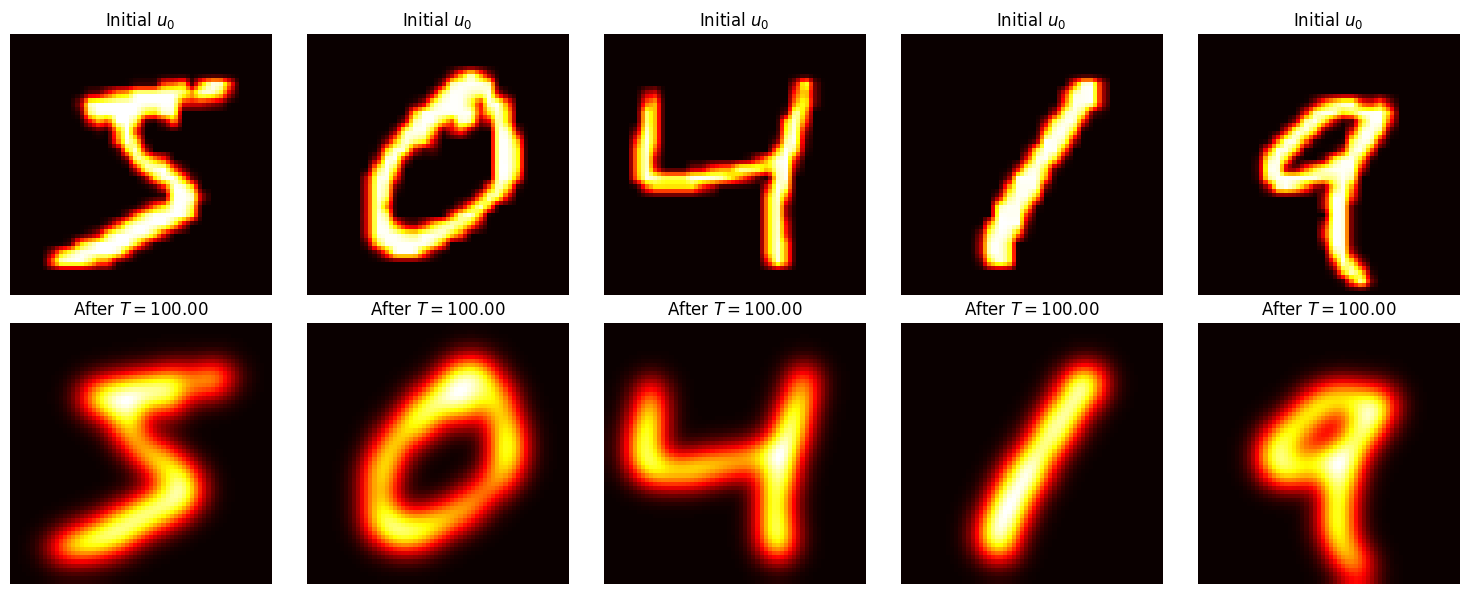

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0,i].imshow(u0_batch[i].numpy(), cmap='hot')
    axs[0,i].set_title('Initial $u_0$')
    axs[0,i].axis('off')
    axs[1,i].imshow(uT_batch[i].numpy(), cmap='hot')
    axs[1,i].set_title('After $T=%.2f$' % T_final)
    axs[1,i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
torch.save({
    'u0': u0_batch,
    'uT': uT_batch,
}, './data/heat_dataset.pt')

In [ ]:
class InverseHeatNDO(nn.Module):
    def __init__(self, modes=(16,16), hidden_channels=32):

        #super().__init__()

        self.fno = FNO2d(
            in_channels=1,
            out_channels=1,
            n_modes_width=modes[0],
            n_modes_height=modes[1],
            hidden_channels=hidden_channels,
        )

    def forward(self, uT, s_span=None):

        if s_span is None:
            s_span = torch.tensor([0.0, 1.0], device=uT.device)

        def vfield(s, u):

            return self.fno(u)

        us = odeint(vfield, uT, s_span, atol=1e-5, rtol=1e-5)
        return us[-1]

In [5]:
data = torch.load('./data/heat_dataset.pt')
u0_data = data['u0']          # (N, H, W)
uT_data = data['uT']          # (N, H, W)

# Add channel dimension: (N, 1, H, W)
u0_data = u0_data.unsqueeze(1).to(device)
uT_data = uT_data.unsqueeze(1).to(device)

dataset = TensorDataset(uT_data, u0_data)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
model = InverseHeatNDO(modes=(16,16), hidden_channels=32).to(device)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = torch.nn.MSELoss()
num_epochs = 200

In [ ]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for uT_batch, u0_batch in dataloader:
        torch.cuda.empty_cache()

        u0_pred = model(uT_batch)

        loss = loss_fn(u0_pred, u0_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * uT_batch.size(0)

    epoch_loss /= len(dataloader.dataset)
    print(f'epoch {epoch:2d}/{num_epochs} — L2 loss: {epoch_loss:.4e}')

Epoch  1/200 — L2 Loss: 1.5607e-02
Epoch  2/200 — L2 Loss: 1.5376e-02
Epoch  3/200 — L2 Loss: 1.5038e-02
Epoch  4/200 — L2 Loss: 1.4194e-02
Epoch  5/200 — L2 Loss: 1.2471e-02
Epoch  6/200 — L2 Loss: 1.0911e-02
Epoch  7/200 — L2 Loss: 8.7755e-03
Epoch  8/200 — L2 Loss: 6.6587e-03
Epoch  9/200 — L2 Loss: 5.3373e-03
Epoch 10/200 — L2 Loss: 4.2183e-03
Epoch 11/200 — L2 Loss: 3.4158e-03
Epoch 12/200 — L2 Loss: 2.9557e-03
Epoch 13/200 — L2 Loss: 2.5164e-03
Epoch 14/200 — L2 Loss: 2.2260e-03
Epoch 15/200 — L2 Loss: 2.0334e-03
Epoch 16/200 — L2 Loss: 1.8622e-03
Epoch 17/200 — L2 Loss: 1.7350e-03
Epoch 18/200 — L2 Loss: 1.6359e-03
Epoch 19/200 — L2 Loss: 1.5484e-03
Epoch 20/200 — L2 Loss: 1.4759e-03
Epoch 21/200 — L2 Loss: 1.4066e-03
Epoch 22/200 — L2 Loss: 1.3385e-03
Epoch 23/200 — L2 Loss: 1.2661e-03
Epoch 24/200 — L2 Loss: 1.2299e-03
Epoch 25/200 — L2 Loss: 1.1907e-03
Epoch 26/200 — L2 Loss: 1.1622e-03
Epoch 27/200 — L2 Loss: 1.1402e-03
Epoch 28/200 — L2 Loss: 1.1178e-03
Epoch 29/200 — L2 Lo

KeyboardInterrupt: 

In [21]:
examples = []

with torch.no_grad():
    for uT_batch, u0_batch in dataloader:
        u0_pred = model(uT_batch, s_span=torch.tensor([0.0, 1.0], device=device))

        if len(examples) < 4:
            print('yep')
            examples.append((u0_batch.cpu(), u0_pred.cpu(), uT_batch.cpu()))

yep
yep
yep
yep


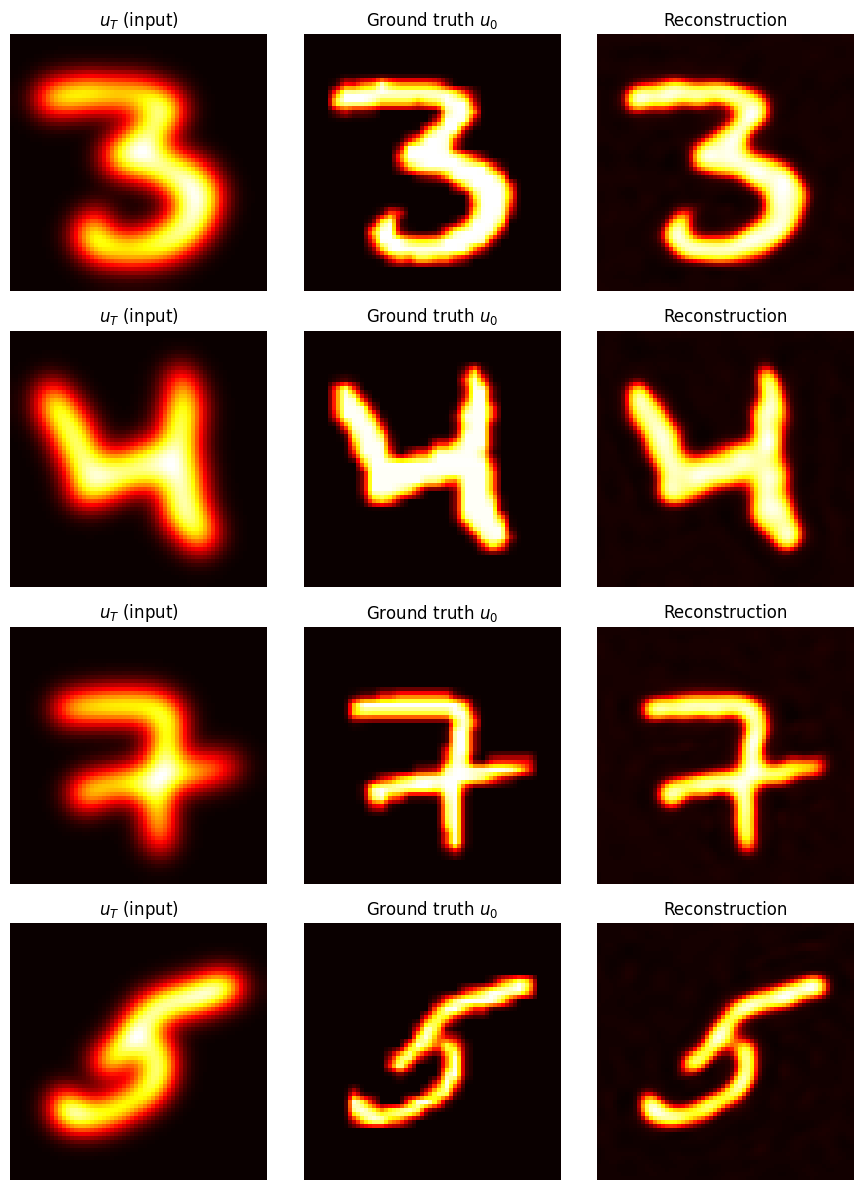

In [22]:
fig, axes = plt.subplots(len(examples), 3, figsize=(9, 3*len(examples)))
for i, (u0_true, u0_pred, uT) in enumerate(examples):
    axes[i,0].imshow(uT[0,0], cmap='hot')
    axes[i,0].set_title('$u_T$ (input)')
    axes[i,1].imshow(u0_true[0,0], cmap='hot')
    axes[i,1].set_title('Ground truth $u_0$')
    axes[i,2].imshow(u0_pred[0,0], cmap='hot')
    axes[i,2].set_title('Reconstruction')
    for ax in axes[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()
